In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from collections import Counter
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim import corpora
from gensim.models import LdaModel


In [2]:
# Load the CSV file
file_path = r'C:\Users\MSI\Documents\start\Financial_News_and_Stock_Price_Integration_Dataset_Analysist\dataset\raw_analyst_ratings.csv'  # Replace with your actual file path
df = pd.read_csv(file_path)



Descriptive Statistics for Headline Lengths:
count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


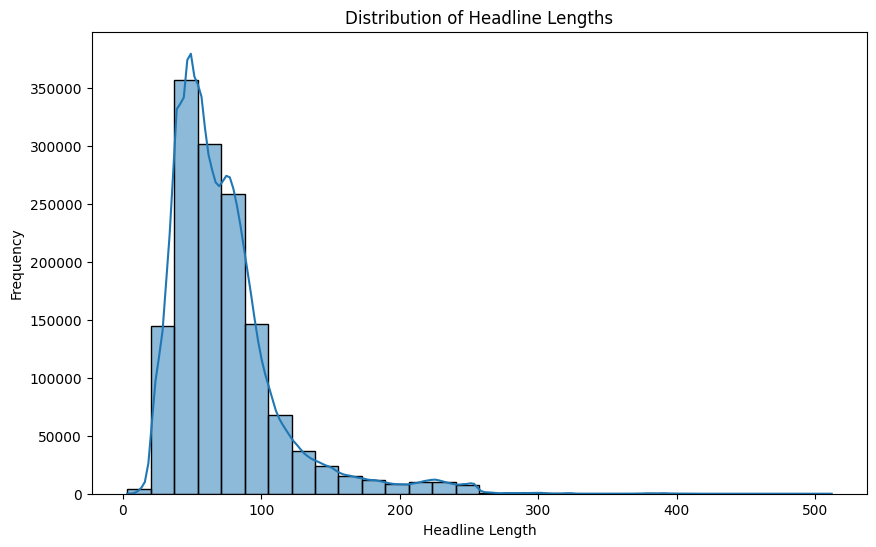


Number of Articles per Publisher:
publisher
Paul Quintaro                      228373
Lisa Levin                         186979
Benzinga Newsdesk                  150484
Charles Gross                       96732
Monica Gerson                       82380
                                    ...  
Shazir Mucklai - Imperium Group         1
Laura Jennings                          1
Eric Martin                             1
Jose Rodrigo                            1
Jeremie Capron                          1
Name: count, Length: 1034, dtype: int64


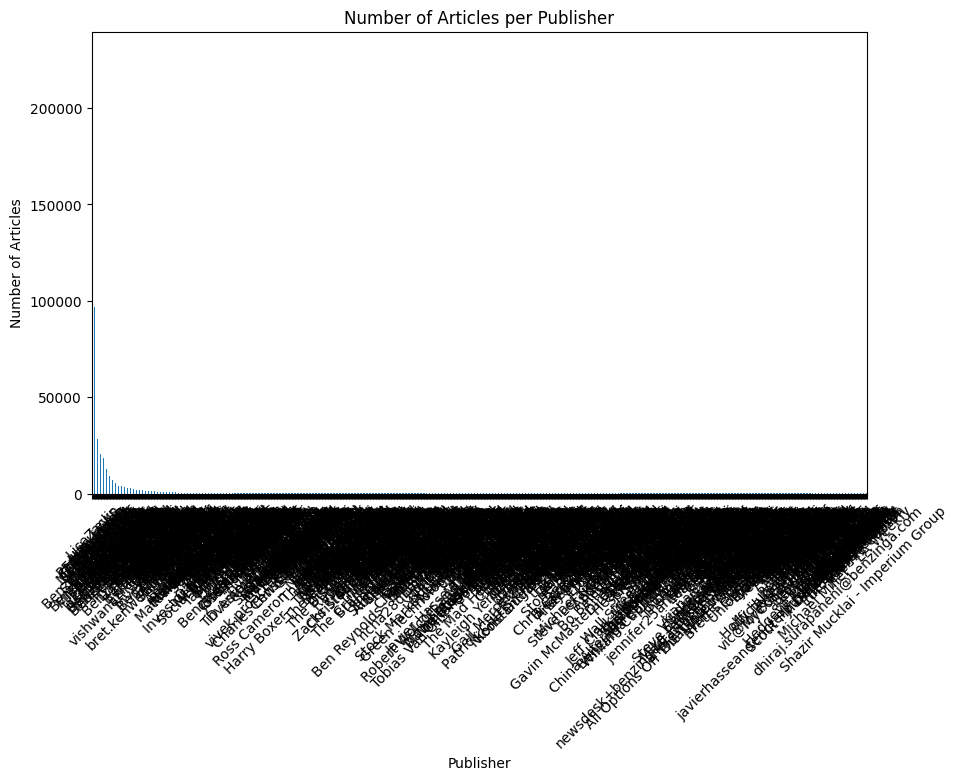


Number of Articles Published Over Time:
publication_date
2009-02-14      1
2009-04-27      2
2009-04-29      1
2009-05-22      1
2009-05-27      6
             ... 
2020-05-30     14
2020-05-31     17
2020-06-01    205
2020-06-02    183
2020-06-03     69
Length: 3946, dtype: int64


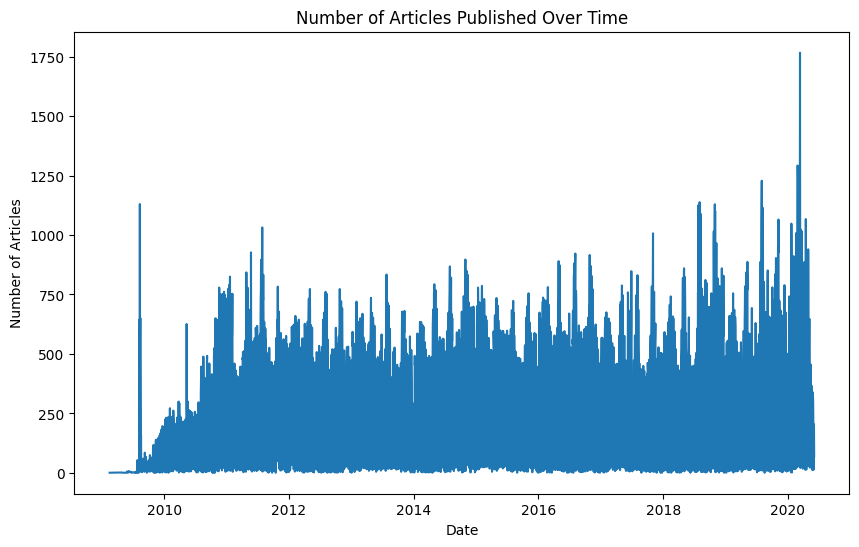


Number of Articles by Day of the Week:
day_of_week
Monday       254842
Tuesday      285468
Wednesday    289049
Thursday     289907
Friday       208511
Saturday       7486
Sunday        16078
Name: count, dtype: int64


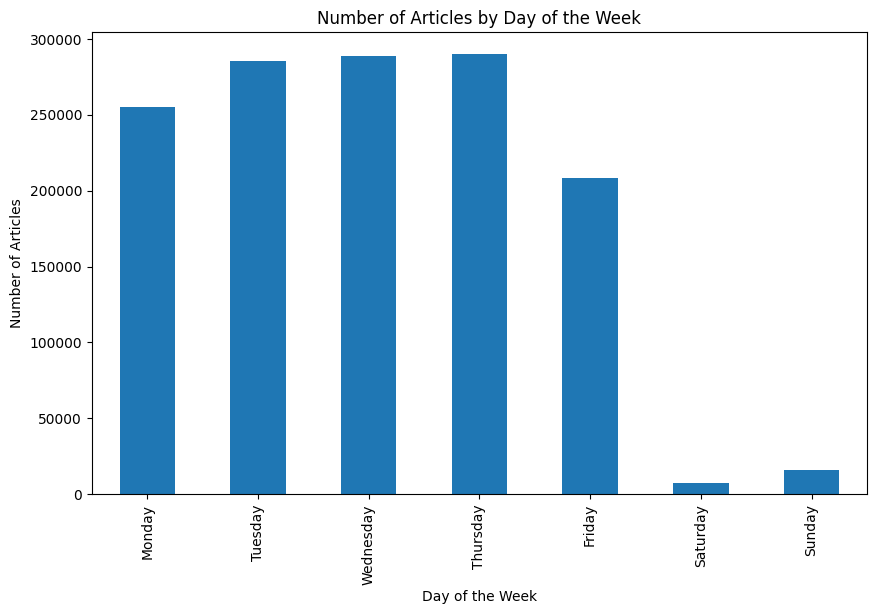

In [5]:
# Convert the date column to datetime format
# Using format='%Y-%m-%d %H:%M:%S' to match your data format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Task 1: Descriptive Statistics for textual lengths (like headline length)
df['headline_length'] = df['headline'].apply(len)
headline_stats = df['headline_length'].describe()
print("Descriptive Statistics for Headline Lengths:")
print(headline_stats)

# Visualize the distribution of headline lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['headline_length'], bins=30, kde=True)
plt.title('Distribution of Headline Lengths')
plt.xlabel('Headline Length')
plt.ylabel('Frequency')
plt.show()

# Task 2: Count the number of articles per publisher
publisher_counts = df['publisher'].value_counts()
print("\nNumber of Articles per Publisher:")
print(publisher_counts)

# Visualize the number of articles per publisher
plt.figure(figsize=(10, 6))
publisher_counts.plot(kind='bar')
plt.title('Number of Articles per Publisher')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.show()

# Task 3: Analyze publication dates to see trends over time
# Extracting the date part (ignoring the time)
df['publication_date'] = df['date'].dt.date
df['day_of_week'] = df['date'].dt.day_name()

# Group by date to get the number of articles per day
articles_per_day = df.groupby('publication_date').size()

print("\nNumber of Articles Published Over Time:")
print(articles_per_day)

# Visualize the number of articles over time
plt.figure(figsize=(10, 6))
articles_per_day.plot(kind='line')
plt.title('Number of Articles Published Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.show()

# Analyze the number of articles by day of the week
articles_by_day = df['day_of_week'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
print("\nNumber of Articles by Day of the Week:")
print(articles_by_day)

# Visualize the number of articles by day of the week
plt.figure(figsize=(10, 6))
articles_by_day.plot(kind='bar')
plt.title('Number of Articles by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Articles')
plt.show()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


Sentiment Distribution:
sentiment
neutral     934928
positive    341161
negative    131239
Name: count, dtype: int64


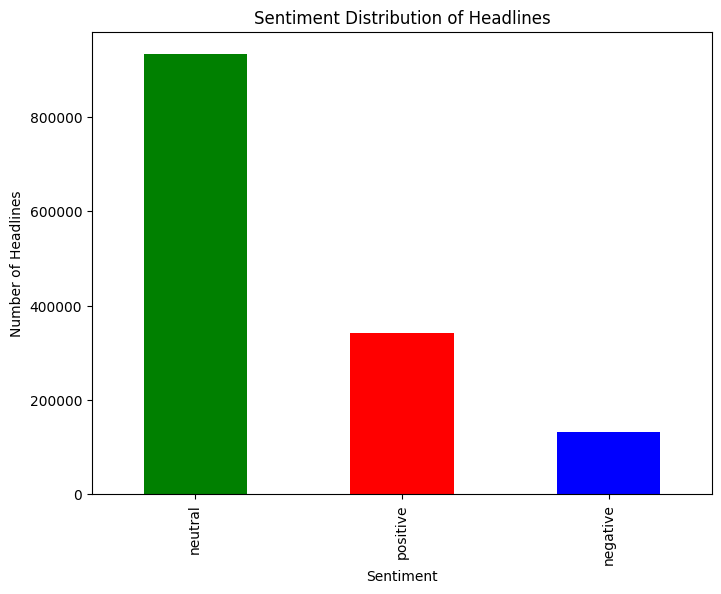

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\MSI/nltk_data'
    - 'c:\\Users\\MSI\\.conda\\envs\\solar_radiation\\nltk_data'
    - 'c:\\Users\\MSI\\.conda\\envs\\solar_radiation\\share\\nltk_data'
    - 'c:\\Users\\MSI\\.conda\\envs\\solar_radiation\\lib\\nltk_data'
    - 'C:\\Users\\MSI\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [3]:


# Ensure necessary NLTK data is downloaded
nltk.download('punkt')
nltk.download('stopwords')

# # Load the CSV file
# file_path = 'your_file_path.csv'  # Replace with your actual file path
# df = pd.read_csv(file_path)

# Task 1: Sentiment Analysis
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

df['sentiment_score'] = df['headline'].apply(get_sentiment)

# Categorize the sentiment into positive, negative, and neutral
df['sentiment'] = df['sentiment_score'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

# Display sentiment distribution
sentiment_distribution = df['sentiment'].value_counts()
print("Sentiment Distribution:")
print(sentiment_distribution)

# Visualize sentiment distribution
plt.figure(figsize=(8, 6))
sentiment_distribution.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Sentiment Distribution of Headlines')
plt.xlabel('Sentiment')
plt.ylabel('Number of Headlines')
plt.show()

# Task 2: Topic Modeling and Keyword Extraction
# Preprocess the text
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text.lower())
    # Remove stopwords and punctuation
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

df['tokens'] = df['headline'].apply(preprocess_text)

# Create a frequency distribution of the tokens
all_words = [word for tokens in df['tokens'] for word in tokens]
fdist = FreqDist(all_words)
common_words = fdist.most_common(20)
print("\nMost Common Words:")
print(common_words)

# Visualize the most common words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(fdist)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Task 3: Topic Modeling using LDA (Latent Dirichlet Allocation)
# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(df['tokens'])
# Create a corpus
corpus = [dictionary.doc2bow(tokens) for tokens in df['tokens']]

# Train LDA model
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)

# Print the topics
topics = lda_model.print_topics(num_words=5)
print("\nIdentified Topics:")
for topic in topics:
    print(topic)

# Visualizing the topics with their corresponding word distributions
for idx, topic in topics:
    print(f"Topic {idx+1}:")
    print(topic)
    print("\n")

# Visualize topic distributions
for i, topic in lda_model.show_topics(formatted=False, num_topics=5, num_words=10):
    words, weights = zip(*topic)
    plt.figure(figsize=(8, 6))
    plt.barh(words, weights, color='blue')
    plt.title(f'Topic {i+1}')
    plt.gca().invert_yaxis()
    plt.show()


In [14]:
import nltk

# Download the required NLTK data files
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Sentiment Distribution:
sentiment
neutral     934928
positive    341161
negative    131239
Name: count, dtype: int64


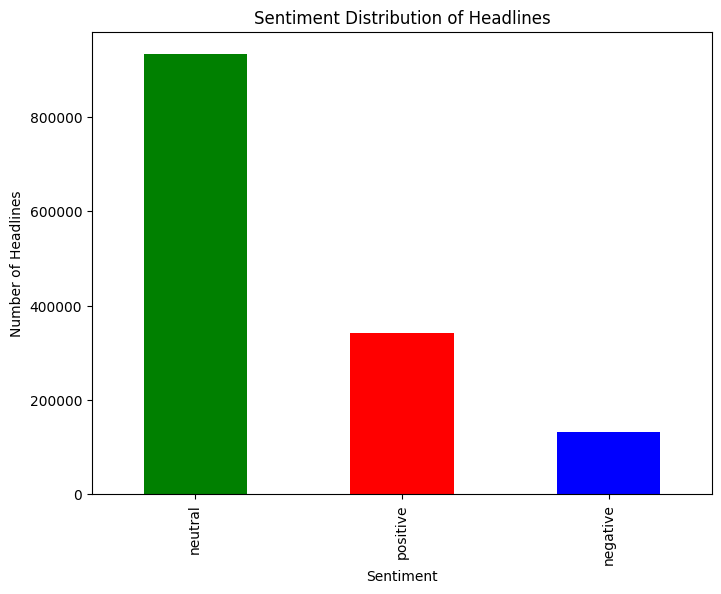

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\MSI/nltk_data'
    - 'c:\\Users\\MSI\\.conda\\envs\\solar_radiation\\nltk_data'
    - 'c:\\Users\\MSI\\.conda\\envs\\solar_radiation\\share\\nltk_data'
    - 'c:\\Users\\MSI\\.conda\\envs\\solar_radiation\\lib\\nltk_data'
    - 'C:\\Users\\MSI\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [17]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim import corpora
from gensim.models import LdaModel

# Ensure necessary NLTK data is downloaded
nltk.download('punkt')
nltk.download('stopwords')

# # Load the CSV file
# file_path = 'your_file_path.csv'  # Replace with your actual file path
# df = pd.read_csv(file_path)

# Task 1: Sentiment Analysis
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

df['sentiment_score'] = df['headline'].apply(get_sentiment)

# Categorize the sentiment into positive, negative, and neutral
df['sentiment'] = df['sentiment_score'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

# Display sentiment distribution
sentiment_distribution = df['sentiment'].value_counts()
print("Sentiment Distribution:")
print(sentiment_distribution)

# Visualize sentiment distribution
plt.figure(figsize=(8, 6))
sentiment_distribution.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Sentiment Distribution of Headlines')
plt.xlabel('Sentiment')
plt.ylabel('Number of Headlines')
plt.show()

# Task 2: Topic Modeling and Keyword Extraction
# Preprocess the text
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text.lower())
    # Remove stopwords and punctuation
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

df['tokens'] = df['headline'].apply(preprocess_text)

# Create a frequency distribution of the tokens
all_words = [word for tokens in df['tokens'] for word in tokens]
fdist = FreqDist(all_words)
common_words = fdist.most_common(20)
print("\nMost Common Words:")
print(common_words)

# Visualize the most common words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(fdist)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Task 3: Topic Modeling using LDA (Latent Dirichlet Allocation)
# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(df['tokens'])
# Create a corpus
corpus = [dictionary.doc2bow(tokens) for tokens in df['tokens']]

# Train LDA model
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)

# Print the topics
topics = lda_model.print_topics(num_words=5)
print("\nIdentified Topics:")
for topic in topics:
    print(topic)

# Visualizing the topics with their corresponding word distributions
for i, topic in lda_model.show_topics(formatted=False, num_topics=5, num_words=10):
    words, weights = zip(*topic)
    plt.figure(figsize=(8, 6))
    plt.barh(words, weights, color='blue')
    plt.title(f'Topic {i+1}')
    plt.gca().invert_yaxis()
    plt.show()


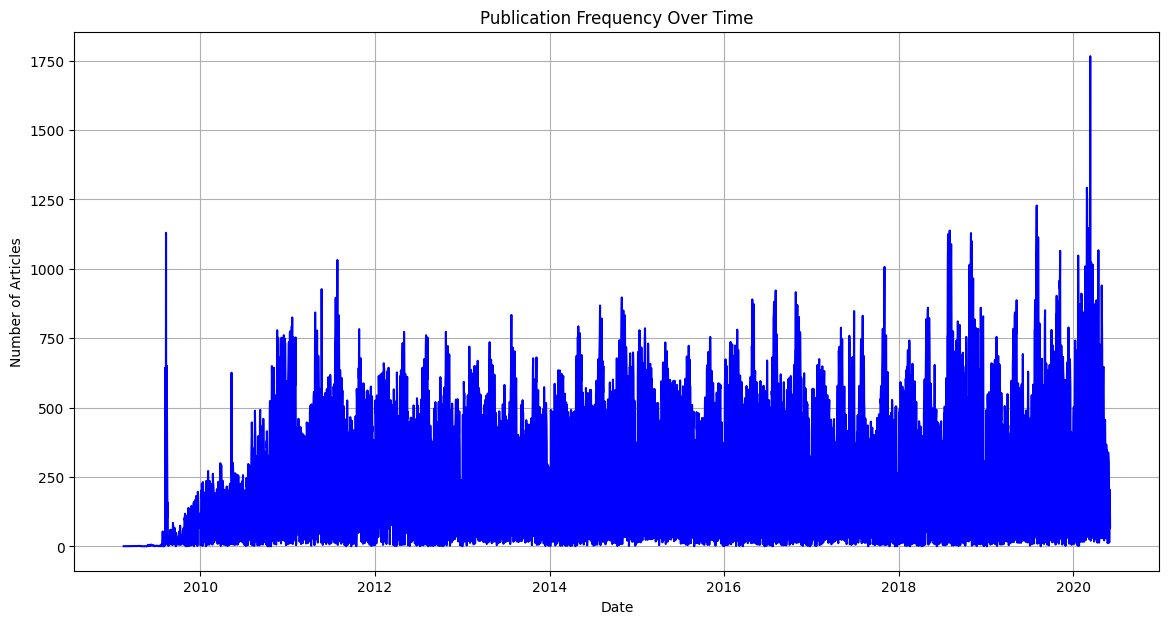

Detected spikes in article publications:
publication_date
2009-06-01      5
2009-06-05      6
2009-06-09      7
2009-07-21      7
2009-07-27     54
             ... 
2020-04-29    940
2020-04-30    839
2020-05-26    339
2020-05-27    320
2020-05-28    304
Length: 941, dtype: int64


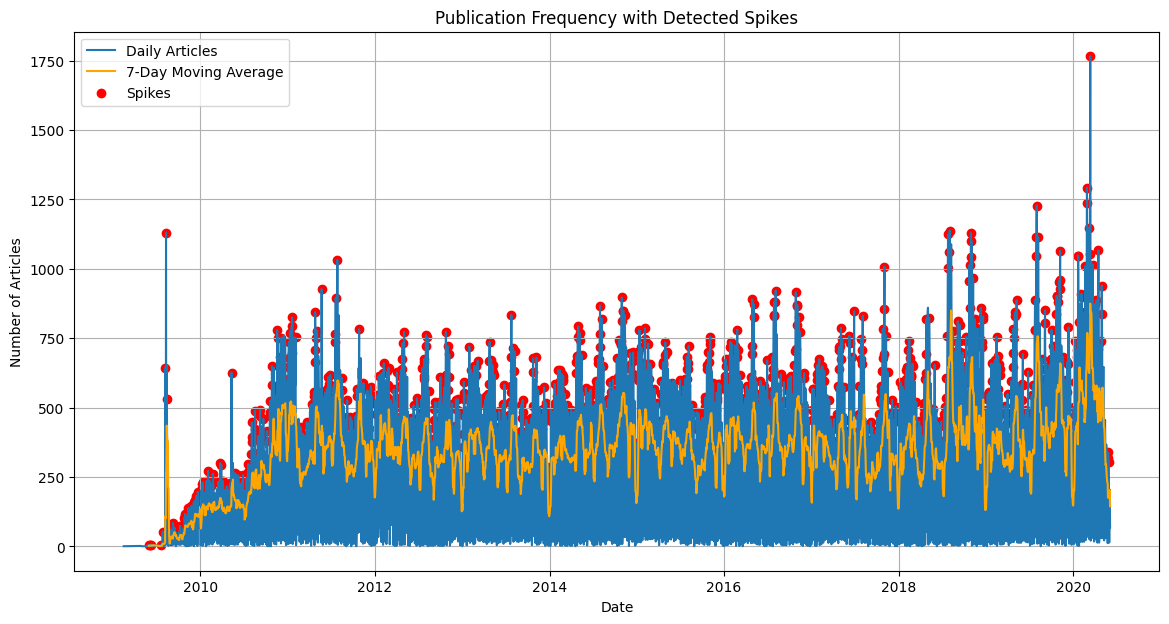

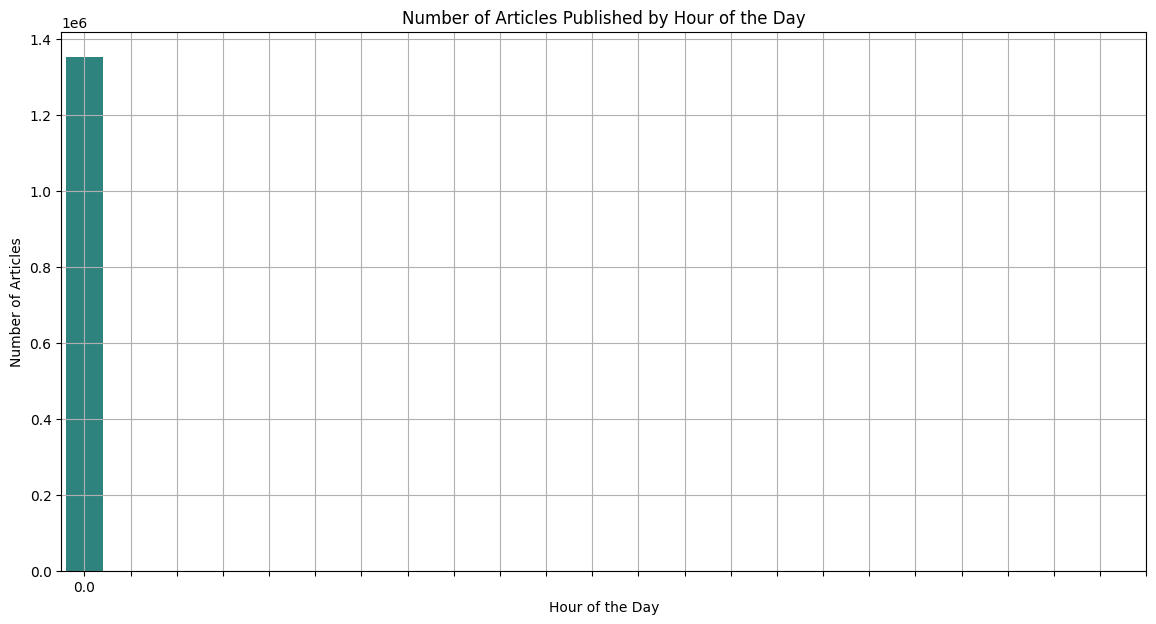

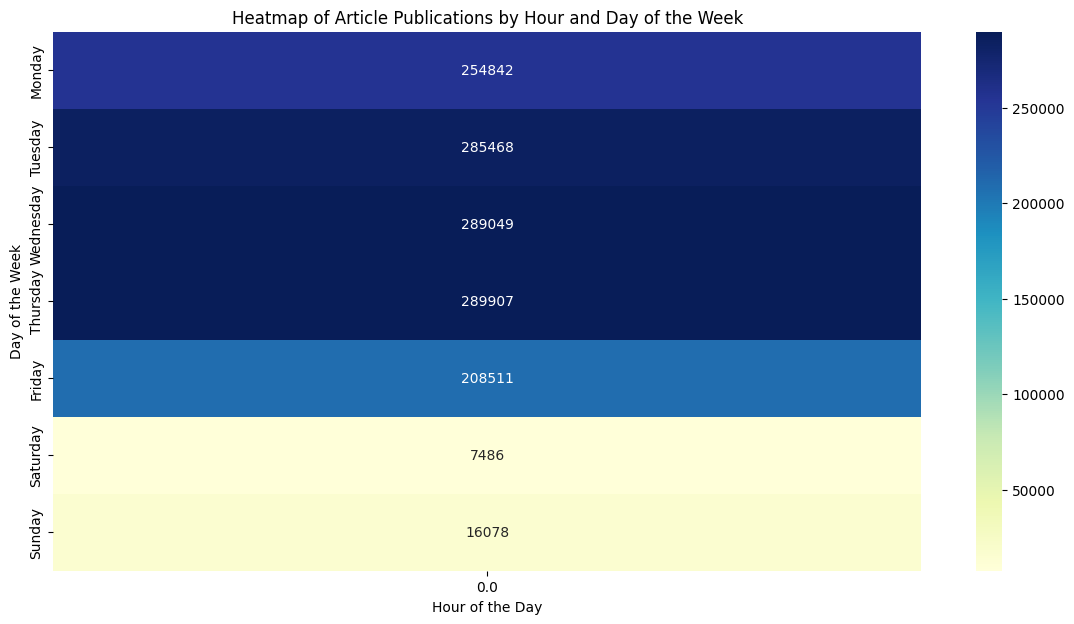

In [13]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Load the CSV file
# file_path = 'your_file_path.csv'  # Replace with your actual file path
# df = pd.read_csv(file_path)

# Convert the date column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Task 1: Publication Frequency Over Time

# Group by date to count the number of articles per day
df['publication_date'] = df['date'].dt.date
articles_per_day = df.groupby('publication_date').size()

# Plotting publication frequency over time
plt.figure(figsize=(14, 7))
articles_per_day.plot(kind='line', color='blue')
plt.title('Publication Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.show()

# Task 2: Detecting Spikes in Article Publications
# To identify spikes, we'll highlight days with article counts that are significantly higher than the moving average.

# Calculate a 7-day moving average
articles_per_day_ma = articles_per_day.rolling(window=7).mean()

# Identify spikes by comparing the actual number of articles to the moving average
spikes = articles_per_day[articles_per_day > 1.5 * articles_per_day_ma]
print("Detected spikes in article publications:")
print(spikes)

# Plot the spikes on top of the original time series
plt.figure(figsize=(14, 7))
plt.plot(articles_per_day, label='Daily Articles')
plt.plot(articles_per_day_ma, label='7-Day Moving Average', color='orange')
plt.scatter(spikes.index, spikes, color='red', label='Spikes')
plt.title('Publication Frequency with Detected Spikes')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.legend()
plt.grid(True)
plt.show()

# Task 3: Analysis of Publishing Times

# Extract the hour from the datetime
df['publication_hour'] = df['date'].dt.hour

# Group by hour to count the number of articles published each hour
articles_per_hour = df.groupby('publication_hour').size()

# Plot the distribution of publishing times
plt.figure(figsize=(14, 7))
sns.barplot(x=articles_per_hour.index, y=articles_per_hour.values, palette='viridis' ,hue=articles_per_hour.index,legend=False)
plt.title('Number of Articles Published by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Articles')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()



# Optional: Heatmap of publication times by hour and day of the week
df['day_of_week'] = df['date'].dt.day_name()
hourly_distribution = df.groupby(['day_of_week', 'publication_hour']).size().unstack().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(14, 7))
sns.heatmap(hourly_distribution, cmap='YlGnBu', annot=True, fmt="d")
plt.title('Heatmap of Article Publications by Hour and Day of the Week')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.show()


# Publisher Analysis
To perform a publisher analysis, we'll focus on the following tasks:

1. **Identify the Most Active Publishers**: Determine which publishers contribute the most to the news feed.
2. **Analyze Differences in News Type**: Explore whether there is a difference in the type of news reported by different publishers.
3. **Unique Domains Analysis**: If publishers are identified by email addresses, extract and analyze the unique domains to see which organizations contribute most frequently.

### Explanation of the Code:

1. **Identify the Most Active Publishers**:
   - **Counting Articles**: The script uses `value_counts()` to count the number of articles contributed by each publisher.
   - **Visualization**: The top 10 publishers are visualized using a bar chart.

2. **Analyze Differences in News Type**:
   - **Pivot Table**: A pivot table is created to analyze how different publishers contribute to different types of news. Here, we assume that the 'stock' column represents different news types or related stock symbols.
   - **Stacked Bar Chart**: The distribution of news types for the top 5 publishers is visualized using a stacked bar chart.

3. **Unique Domains Analysis**:
   - **Domain Extraction**: A regular expression is used to extract domains from publisher names, assuming they might be email addresses.
   - **Counting Domains**: The script counts the occurrences of each domain to identify which organizations contribute the most.
   - **Visualization**: The top 10 domains are visualized using a bar chart.

### Next Steps:
- **Deeper Analysis**: You could perform more granular analysis on specific publishers or domains to understand their impact on the news feed.
- **Content Analysis**: If there is text data available, you can analyze the sentiment or topics associated with different publishers or domains.
- **Time Series Correlation**: Analyze if certain publishers are more active during specific market events.

Would you like to refine this analysis further or explore another aspect?

Top Publishers by Number of Articles:
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


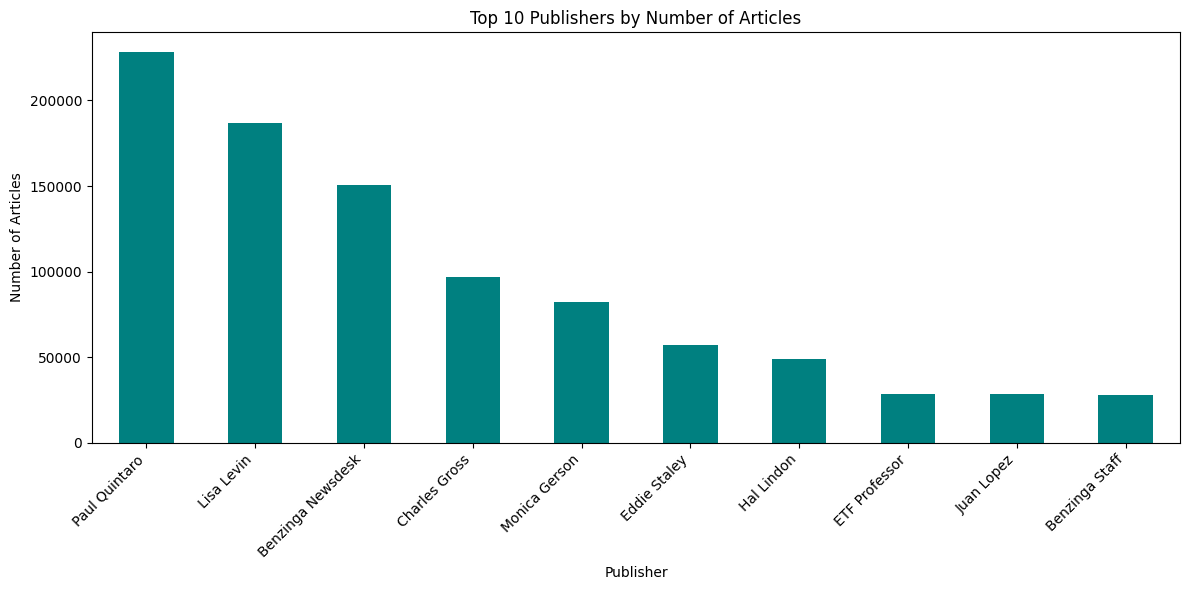


News Type Distribution for Top Publishers:
stock                A   AA  AAC  AADR  AAL  AAMC  AAME  AAN  AAOI  AAON  ...  \
publisher                                                                 ...   
Benzinga Newsdesk   81  109   23     0  229    10     9   42    55    21  ...   
Benzinga Staff     438   76    3     0    0     0     4   11     0     3  ...   
Charles Gross       27  175   12     0    4     2     0   23    18     1  ...   
ETF Professor        0   29    0     2    0     0     0    0     0     0  ...   
Eddie Staley        27   65    5     0   29     1     2   10    17     5  ...   
Hal Lindon          36   72   10     0   10     3     7   18    13     4  ...   
Juan Lopez          33   30    0     0    5     0     0    5     1     0  ...   
Lisa Levin         126  253   57     0    0     6     6   80   114    14  ...   
Monica Gerson       68  216    2     0    0     2     5   21     2    34  ...   
Paul Quintaro      127  297   41     0   98    12    14   98    8

<Figure size 1600x1200 with 0 Axes>

ValueError: Image size of 735x128170 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>


Top Domains by Number of Articles:
domain
benzinga.com              7937
gmail.com                  139
andyswan.com                 5
investdiva.com               2
tothetick.com                2
eosdetroit.io                1
forextraininggroup.com       1
stockmetrix.net              1
Name: count, dtype: int64


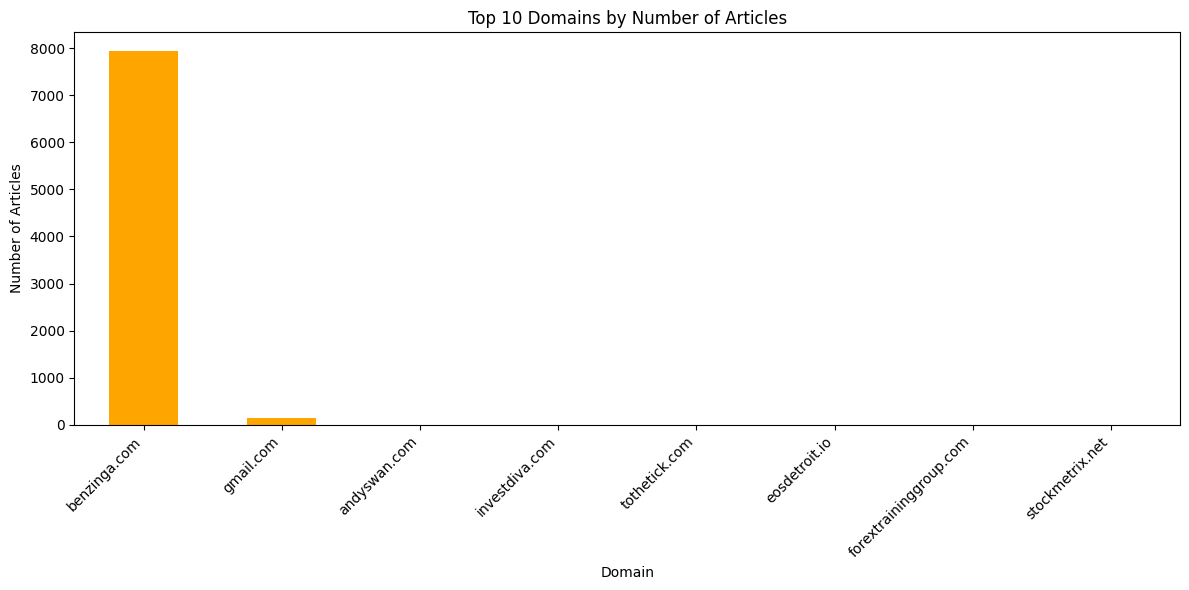

In [11]:

# Task 1: Identify the Most Active Publishers
publisher_counts = df['publisher'].value_counts()

# Limit to top 10 publishers to avoid excessive data points
top_publishers = publisher_counts.head(10)
print("Top Publishers by Number of Articles:")
print(top_publishers)

# Visualize the most active publishers with limited categories
plt.figure(figsize=(12, 6))  # Ensure the figure size is manageable
top_publishers.plot(kind='bar', color='teal')
plt.title('Top 10 Publishers by Number of Articles')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()  # Adjusts plot to fit within the figure area
plt.show()

# Task 2: Analyze Differences in News Type
# Assuming 'stock' column indicates the type of news or related stock symbol
# Limit to top 5 publishers
top_publishers_list = top_publishers.index

# Filter the dataframe to include only top publishers
df_top_publishers = df[df['publisher'].isin(top_publishers_list)]

# Pivot table to see the count of different news types per publisher
news_type_distribution = pd.pivot_table(df_top_publishers, values='headline', index='publisher', 
                                        columns='stock', aggfunc='count', fill_value=0)

print("\nNews Type Distribution for Top Publishers:")
print(news_type_distribution)

# Visualize the distribution of news types by top publishers
plt.figure(figsize=(16, 12))  # Ensure the figure size is appropriate
news_type_distribution.plot(kind='bar', stacked=True, colormap='tab20c')
plt.title('Distribution of News Types by Top 5 Publishers')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha="right")
plt.legend(title='Stock', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()  # Adjusts plot to fit within the figure area
plt.show()

# Task 3: Unique Domains Analysis from Email Addresses
def extract_domain(email):
    # Use regex to extract domain from email addresses
    match = re.search(r'@([\w.-]+)', email)
    return match.group(1) if match else None

# Extract domain names from publisher names
df['domain'] = df['publisher'].apply(extract_domain)

# Count the occurrences of each domain
domain_counts = df['domain'].value_counts()

# Limit to top 10 domains to avoid excessive data points
top_domains = domain_counts.head(10)
print("\nTop Domains by Number of Articles:")
print(top_domains)

# Visualize the top domains
plt.figure(figsize=(12, 6))  # Ensure the figure size is manageable
top_domains.plot(kind='bar', color='orange')
plt.title('Top 10 Domains by Number of Articles')
plt.xlabel('Domain')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()  # Adjusts plot to fit within the figure area
plt.show()
